<a href="https://colab.research.google.com/github/SitiFadhilahRahmi/Portfolio_SitiFadhilah/blob/main/TwitterSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [ ]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

Load Data

In [ ]:
data = pd.read_csv('/content/data.csv', encoding='latin-1')

kata_tidak_baku = pd.read_csv('/content/new_kamusalay.csv', encoding='latin-1', header=None)

id_stopword_dict = pd.read_csv('/content/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

abusive_dict = pd.read_csv('/content/abusive.csv')['ABUSIVE'].tolist()

Data Shape

In [ ]:
print("Shape: ", data.shape)
data.head(5)

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [ ]:
print("Shape: ", kata_tidak_baku.shape)
kata_tidak_baku.head(15)

Shape:  (15167, 2)


,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [ ]:
print("Shape: ", id_stopword_dict.shape)
id_stopword_dict.head()

Shape:  (758, 1)


,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


Preprocess Data

In [ ]:
kata_tidak_baku

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [ ]:
import re
import unicodedata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text)
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alay_dict_map = dict(zip(kata_tidak_baku[0], kata_tidak_baku[1]))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text): # mengembalikan kata ke bentuk asal dan menghilangkan kata yg tidak diperlukan seperti imbuhan dan konjungsi
    return stemmer.stem(text)

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [ ]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    text = remove_unicode(text)
    text = remove_extra_spaces(text)
    return text

In [ ]:
data['Tweet'] = data['Tweet'].apply(preprocess)

Splitting Dataset

In [ ]:
# label dataframe
df_HS = data[['Tweet', 'HS']]
df_Abusive = data[['Tweet', 'Abusive']]

In [ ]:
#label dataset
df_HS.to_csv("/content/HS.csv")
df_Abusive.to_csv("/content/Abusive.csv")

Modelling

In [ ]:
def vector_model(data, category, vectorizer, ngram):
    X = data['Tweet'].fillna(' ')
    Y = data[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    vector = vectorizer(ngram_range=(ngram), stop_words=id_stopword_dict['stopword'].tolist())

    X_train_scal = vector.fit_transform(X_train)
    X_test_scal = vector.transform(X_test)

    #Decision Tree
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
    dt.fit(X_train_scal, Y_train)
    Y_pred_dt = dt.predict(X_test_scal)
    print(f"\nDT done -> It's classification report for {category} \n {classification_report(Y_test, Y_pred_dt)} ")

    f1_scores = [round(f1_score(Y_pred_dt, Y_test), 2)]

In [ ]:
data_HS = pd.read_csv('/content/HS.csv')
result_HS = vector_model(data_HS, 'HS', TfidfVectorizer, (1,1))
result_HS


DT done -> It's classification report for HS 
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      2301
           1       0.73      0.74      0.73      1650

    accuracy                           0.78      3951
   macro avg       0.77      0.77      0.77      3951
weighted avg       0.78      0.78      0.78      3951
 


In [ ]:
# Abusive
data_Abusive = pd.read_csv('/content/Abusive.csv')
result_Abusive = vector_model(data_Abusive, 'Abusive', TfidfVectorizer, (1,1))
result_Abusive


DT done -> It's classification report for Abusive 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      2440
           1       0.88      0.85      0.86      1511

    accuracy                           0.90      3951
   macro avg       0.89      0.89      0.89      3951
weighted avg       0.90      0.90      0.90      3951
 


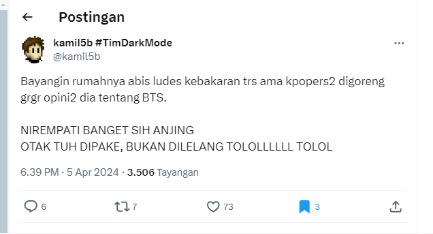

In [ ]:
example1 = ['Bayangin rumahnya abis ludes kebakaran trs ama kpopers2 digoreng grgr opini2 dia tentang BTS. NIREMPATI BANGET SIH ANJING OTAK TUH DIPAKE, BUKAN DILELANG TOLOLLLLLL TOLOL']

In [ ]:
x = df_HS.Tweet.fillna(' ')
y = df_HS['HS']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvHS = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvHS.fit_transform(x_train)
x_test_scal = tfvHS.transform(x_test)
dtHS = DecisionTreeClassifier()

dtHS.fit(x_train_scal, y_train)

DecisionTreeClassifier()

In [ ]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvHS.transform(example1_preprocessed)
zero=dtHS.predict_proba(example1_transform)[:,0][0]
one=dtHS.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('Tweet ini mengandung Hate Speech')
else:
    print('Tweet ini tidak mengandung Hate Speech')

Tweet ini mengandung Hate Speech


In [ ]:
x = df_Abusive.Tweet.fillna(' ')
y = df_Abusive['Abusive']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
tfvAbusive = TfidfVectorizer(ngram_range=(1,1), stop_words=id_stopword_dict['stopword'].tolist())
x_train_scal = tfvAbusive.fit_transform(x_train)
x_test_scal = tfvAbusive.transform(x_test)
dtAbusive = DecisionTreeClassifier()
dtAbusive.fit(x_train_scal, y_train)

DecisionTreeClassifier()

In [ ]:
example1_preprocessed = [preprocess(text) for text in example1]
example1_transform = tfvAbusive.transform(example1_preprocessed)
zero=dtAbusive.predict_proba(example1_transform)[:,0][0]
one=dtAbusive.predict_proba(example1_transform)[:,1][0]
if (zero>=0.42 and one<=0.58) and (zero<=0.58 and one>=0.42):
    print('Neutral')
elif one>0.58:
    print('Tweet ini berisi kata-kata kasar (abusive)')
else:
    print('Tidak ada kata-kata kasar')

Tweet ini berisi kata-kata kasar (abusive)
